# Model Evaluation
For this Notebook, I will implement LassoCV and look at the coefficients that can determine baby weight.

# 1. Data Preprocessing
The original dataset contains 3.8 million rows with 240 columns. <br>
I hand-picked 79 columns to use for this project. Please refer to US_Birth_columns for dictionary key. <br>
In addition, I will take a random sample of 750,000 in order to conserve time and processing capability.

### Libraries to import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy import stats
%matplotlib inline
import random
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

from sklearn.linear_model import LassoCV

In [2]:
# handpicking columns. The original dataset contains 240 columns.
columns = ['dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'mager', 'mbstate_rec', 'restatus', 'mrace6', 'mhisp_r', 'mracehisp', 'dmar', 'meduc', 'fagecomb',
          'frace6', 'fhisp_r', 'fracehisp', 'feduc', 'priorlive', 'priordead', 'priorterm', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'cig_0',
          'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'f_m_ht', 'bmi', 'pwgt_r', 'dwgt_r', 'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
          'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesar', 'rf_cesarn', 'no_risks', 'ip_gon', 'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 
          'no_infec', 'ob_ecvs', 'ob_ecvf', 'ld_indl', 'ld_augm', 'ld_ster', 'ld_antb', 'ld_chor', 'ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial',
          'rdmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'no_mmorb', 'attend', 'mtran', 'pay', 'dplural', 'sex', 'combgest',
          'dbwt']

In [4]:
# taking a random sample of 750,000
n = 3_801_534
s = 750_000
skip = sorted(random.sample(range(1, n + 1), n-s))
df = pd.read_csv('natl2018.csv.zip', low_memory=False, usecols=columns, skiprows=skip)
df.shape

(750000, 79)

In [5]:
df.head()

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest,dbwt
0,1,1227,2,1,30,1,2,10,0,1,1.0,6,31,1,1,7,3,1,0,2,16,33,16,3,8,0,0,0,0,66,1,30.7,190,231,41,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,Y,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,2,1,M,38,3657
1,1,1626,1,1,21,1,1,41,0,4,2.0,2,22,4,0,4,3,0,0,0,888,888,888,3,10,0,0,0,0,62,1,25.2,138,161,23,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,N,N,N,1,1,1,X,1,N,N,N,N,N,1,1,N,1,1,M,39,3635
2,1,114,1,1,35,1,1,10,0,1,1.0,6,37,1,0,1,4,2,0,0,68,888,68,3,12,0,0,0,0,65,1,25.5,153,186,33,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,Y,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,2,1,F,41,3900
3,1,1547,6,1,29,1,1,10,0,1,2.0,4,46,6,0,6,2,0,0,0,888,888,888,2,13,1,1,1,1,63,1,39.0,220,211,0,N,N,N,Y,N,N,N,X,X,N,0,0,N,N,N,N,N,1,N,N,N,N,N,N,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,1,1,M,40,3425
4,1,708,4,2,28,1,1,10,0,1,1.0,5,28,1,0,1,4,3,0,1,18,999,999,3,13,3,1,0,0,68,1,33.4,220,257,37,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,N,N,N,1,1,1,X,1,N,N,N,N,N,1,3,N,2,1,F,40,4607


### Preprocessing
Most of the preprocessing work translates the numeric keys into strings based off the dictionary. <br>
If baby weight and time of birth was unknown, the rows were dropped. <br>
In addition, I imputed age with the average.

In [6]:
def data_cleaning_births(_df):
    """
    Preprocessing columns by translating using column dictionary.
    The order of columns follows the same order as column dictionary.
    """
    
    # Birth Month, leave numbers as is; 12 = December, 01 = January
    _df['dob_mm'] = _df['dob_mm'] 
    
    
    # Time of Birth, dropping unknown
    _df.drop(df[df['dob_tt'].eq(9999)].index, inplace=True)    
    
    
    # Birth Day of Week, leave as is; 7 = Saturday, 1 = Sunday
    _df['dob_wk'] = _df['dob_wk']
    
    # Birth Place; Home(intended) = Home(not intended)
    conditions = [
        _df['bfacil'].eq(1),
        _df['bfacil'].eq(2),
        _df['bfacil'].eq(3),
        _df['bfacil'].eq(4), 
        _df['bfacil'].eq(5),
        _df['bfacil'].eq(6),
        _df['bfacil'].eq(7), 
    ]
    choices = [
        'Hospital',
        'BirthCenter',
        'Home',
        'Home',
        'Home',
        'Clinic',
        'Other'
    ]
    _df['bfacil'] = np.select(conditions, choices, 'Unknown')
    
    # Mother's Single Years of Age; note 0 = 10-12, and 50 = 50 and over
    _df['mager'] = _df['mager']
    
    # Mother's Nativity
    conditions = [
        _df['mbstate_rec'].eq(1),
        _df['mbstate_rec'].eq(2)
    ]
    choices = [
        'BornInUSA',
        'BornOutUSA'
    ]
    _df['mbstate_rec'] = np.select(conditions, choices, 'Unknown')
    
    
    # Residence Status
    conditions = [
        _df['restatus'].eq(1),
        _df['restatus'].eq(2),
        _df['restatus'].eq(3)
    ]
    choices = [
        'Resident',
        'IntrastateNonresident',
        'InterstateNonresident'
    ]
    _df['restatus'] = np.select(conditions, choices, 'Foreign')
    
    # Mother's Race Recode 6
    conditions = [
        _df['mrace6'].eq(10),
        _df['mrace6'].eq(20),
        _df['mrace6'].eq(30),
        _df['mrace6'].eq(41),
        _df['mrace6'].eq(51)
    ]
    choices = [
        'White',
        'Black',
        'AIAN',
        'Asian',
        'NHOPI',
    ]
    
    _df['mrace6'] = np.select(conditions, choices, 'Multi')
    
    # Mother's Hispanic Origin
    conditions = [
        _df['mhisp_r'].eq(0),
        _df['mhisp_r'].eq(1),
        _df['mhisp_r'].eq(2),
        _df['mhisp_r'].eq(3),
        _df['mhisp_r'].eq(4),
        _df['mhisp_r'].eq(5),
        _df['mhisp_r'].eq(6)
    ]
    choices = [
        'Non-Hispanic',
        'Mexican',
        'Puerto Rican',
        'Cuban',
        'CentralSouthAmerican',
        'OtherHispanic',
        'Dominican'
    ]
    _df['mhisp_r'] = np.select(conditions, choices, 'Unknown')
    
    # Mother's Race/Hispanic Origin
    conditions = [
        _df['mracehisp'].eq(1),
        _df['mracehisp'].eq(2),
        _df['mracehisp'].eq(3),
        _df['mracehisp'].eq(4),
        _df['mracehisp'].eq(5),
        _df['mracehisp'].eq(6),
        _df['mracehisp'].eq(7),
    ]
    choices = [
        'NonHispanicWhite',
        'NonHispanicBlack',
        'NonHispanicAIAN',
        'NonHispanicAsian',
        'NonHispanicNHOPI',
        'NonHispanicMulti',
        'Hispanic'
    ]
    _df['mracehisp'] = np.select(conditions, choices, 'Unknown')
    
    
    # Marital Status
    _df['dmar'] = np.where(_df['dmar'].eq(1), 'Married', 'Unmarried')
    
    # Mother's Education
    conditions = [
        _df['meduc'].eq(1),
        _df['meduc'].eq(2),
        _df['meduc'].eq(3),
        _df['meduc'].eq(4),
        _df['meduc'].eq(5),
        _df['meduc'].eq(6),
        _df['meduc'].eq(7),
        _df['meduc'].eq(8)
    ]
    choices = [
        'JuniorHighIncomplete',
        'HighSchoolIncomplete',
        'HighSchoolComplete',
        'CollegeIncomplete',
        'AssociateDegree',
        'BachelorDegree',
        'MasterDegree',
        'Doctorate'
    ]
    _df['meduc'] = np.select(conditions, choices, 'Unknown')
    
    # Father's combined Age: imputing missing fathers age with average
    _df['fagecomb'] = np.where(_df['fagecomb'].eq(99), 30, _df['fagecomb'])
    
    # Father's Race recode
    conditions = [
        _df['frace6'].eq(1),
        _df['frace6'].eq(2),
        _df['frace6'].eq(3),
        _df['frace6'].eq(4),
        _df['frace6'].eq(5),
        _df['frace6'].eq(6),
    ]
    choices = [
        'White',
        'Black',
        'AIAN',
        'Asian',
        'NHOPI',
        'Multi'
    ]
    _df['frace6'] = np.select(conditions, choices, 'Unknown')
    
    # Father's Hispanic Origin
    conditions = [
        _df['fhisp_r'].eq(0),
        _df['fhisp_r'].eq(1),
        _df['fhisp_r'].eq(2),
        _df['fhisp_r'].eq(3),
        _df['fhisp_r'].eq(4),
        _df['fhisp_r'].eq(5),
        _df['fhisp_r'].eq(6)
    ]
    choices = [
        'NonHispanic',
        'Mexican',
        'PuertoRican',
        'Cuban',
        'CentralSouthAmerican',
        'Dominican',
        'OtherHispanic'
    ]
    _df['fhisp_r'] = np.select(conditions, choices, 'Unknown')
    
    # Father's Race/Hispanic Origin
    conditions = [
        _df['fracehisp'].eq(1),
        _df['fracehisp'].eq(2),
        _df['fracehisp'].eq(3),
        _df['fracehisp'].eq(4),
        _df['fracehisp'].eq(5),
        _df['fracehisp'].eq(6),
        _df['fracehisp'].eq(7),
        _df['fracehisp'].eq(8)
    ]
    choices = [
        'NonHispanicWhite',
        'NonHispanicBlack',
        'NonHispanicAIAN',
        'NonHispanicAsian',
        'NonHispanicNHOPI',
        'NonHispanicMulti',
        'Hispanic',
        'Unknown'
    ]
    _df['fracehisp'] = np.select(conditions, choices, 'Unknown')
    
    # Father's Education
    conditions = [
        _df['feduc'].eq(1),
        _df['feduc'].eq(2),
        _df['feduc'].eq(3),
        _df['feduc'].eq(4),
        _df['feduc'].eq(5),
        _df['feduc'].eq(6),
        _df['feduc'].eq(7),
        _df['feduc'].eq(8)
    ]
    choices = [
        'JuniorHighIncomplete',
        'HighSchoolIncomplete',
        'HighSchoolComplete',
        'CollegeIncomplete',
        'AssociateDegree',
        'BachelorDegree',
        'MasterDegree',
        'Doctorate'
    ]
    _df['feduc'] = np.select(conditions, choices, 'Unknown')
    
    # Prior Births Now Living
    conditions = [
        _df['priorlive'].eq(0),
        _df['priorlive'].eq(1),
        _df['priorlive'].eq(99)
    ]
    choices = [
        'None',
        'One',
        'Unknown'
    ]
    _df['priorlive'] = np.select(conditions, choices, 'Multi')
    
    # Prior Births Now Dead
    conditions = [
        _df['priordead'].eq(0),
        _df['priordead'].eq(1),
        _df['priordead'].eq(99)
    ]
    choices = [
        'None',
        'One',
        'Unknown'
    ]
    _df['priordead'] = np.select(conditions, choices, 'Multi')
    
    # Prior Other Terminations
    conditions = [
        _df['priorterm'].eq(0),
        _df['priorterm'].eq(1),
        _df['priorterm'].eq(99)
    ]
    choices = [
        'None',
        'One',
        'Unknown'
    ]
    _df['priorterm'] = np.select(conditions, choices, 'Multi')
    
    
    # Interval Since Last Live Birth Recode
    _df.drop(df[df['illb_r'].eq(999)].index, inplace=True)    
    _df['illb_r'] = np.where(_df['illb_r'].eq(888), 0, _df['illb_r'])
    
    # Interval since last other Pregnancy
    _df.drop(df[df['ilop_r'].eq(999)].index, inplace=True)    
    _df['ilop_r'] = np.where(_df['ilop_r'].eq(888), 0, _df['ilop_r'])
    
    # Interval since Last pregnancy
    _df.drop(df[df['ilp_r'].eq(999)].index, inplace=True)    
    _df['ilp_r'] = np.where(_df['ilp_r'].eq(888), 0, _df['ilp_r'])
    
    # Month Prenatal Care Began
    _df['precare'] = np.where(_df['precare'].eq(99), 0, _df['precare'])
    
    # Number of Prenatal Visits
    _df['previs'] = np.where(_df['previs'].eq(99), 0, _df['previs'])
    
    # Cigarettes before Pregnancy
    conditions = [
        _df['cig_0'].eq(0),
        _df['cig_0'].eq(99)
    ]
    choices = [
        'None',
        'Unknown'
    ]
    _df['cig_0'] = np.select(conditions, choices, 'Yes')
    
    # Cigarettes 1st Trimester
    conditions = [
        _df['cig_1'].eq(0),
        _df['cig_1'].eq(99)
    ]
    choices = [
        'None',
        'Unknown'
    ]
    _df['cig_1'] = np.select(conditions, choices, 'Yes')
    
    # Cigarettes 2nd Trimester
    conditions = [
        _df['cig_2'].eq(0),
        _df['cig_2'].eq(99)
    ]
    choices = [
        'None',
        'Unknown'
    ]
    _df['cig_2'] = np.select(conditions, choices, 'Yes')
    
    # Cigarettes 3rd Trimester
    conditions = [
        _df['cig_3'].eq(0),
        _df['cig_3'].eq(99)
    ]
    choices = [
        'None',
        'Unknown'
    ]
    _df['cig_3'] = np.select(conditions, choices, 'Yes')
    
    
    # Mother's Height in Total Inches: imputing average height if missing
    _df['m_ht_in'] = np.where(_df['m_ht_in'].eq(99), 64, _df['m_ht_in'])
    
    # Height Reported
    _df['f_m_ht'] = _df['f_m_ht']
    
    
    # Body Mass Index: if missing, impute mean
    _df['bmi'] = np.where(_df['bmi'].eq(99), 27.9, _df['bmi'])
    
    # Pre-pregnancy weight
    _df['pwgt_r'] = np.where(_df['pwgt_r'].eq(999), 164, _df['pwgt_r'])
    
    
    # Delivery Weight Recode
    _df['dwgt_r'] = np.where(_df['dwgt_r'].eq(999), 193, _df['dwgt_r'])
    
    
    # Weight Gain
    _df['wtgain'] = np.where(_df['wtgain'].eq(99), _df['dwgt_r'] - _df['pwgt_r'], _df['wtgain'])
    
    # Pre-pregnancy Diabetes
    # .... skipping columns leaving as is. Y = Yes, N= No, U = Unknown, X = Not Applicable
    # Previous Cesarean
    
    # Number of Previous Cesareans
    conditions = [
        _df['rf_cesarn'].eq(0),
        _df['rf_cesarn'].eq(1),
        _df['rf_cesarn'].eq(99),
    ]
    choices = [
        'None',
        'One',
        'Unknown'
    ]
    _df['rf_cesarn'] = np.select(conditions, choices, 'Multi')
    
    
    # No Risk Factors Reported
    conditions = [
        _df['no_risks'].eq(1),
        _df['no_risks'].eq(0)
    ]
    choices = [
        'Y',
        'N'
    ]
    _df['no_risks'] = np.select(conditions, choices, 'U')
    
    # IP_GON Gonorrhea
    # ... skipping columns, leaving as is. Y= Yes, N= No, U= Unknown
    # IP_HEPC Hepatitis c
    
    # No Infections Reported
    conditions = [
        _df['no_infec'].eq(1),
        _df['no_infec'].eq(0)
    ]
    choices = [
        'Y',
        'N'
    ]
    _df['no_infec'] = np.select(conditions, choices, 'U')
    
    # OB_ECVS Successful External Cephalic Version
    # ... skipping columns
    # LD_ANES Anesthesia
    
    # No Characteristics of Labor Reported
    conditions = [
        _df['no_lbrdlv'].eq(1),
        _df['no_lbrdlv'].eq(0)
    ]
    choices = [
        'Y',
        'N'
    ]
    _df['no_lbrdlv'] = np.select(conditions, choices, 'U')
    
    
    # Fetal Presentation at Delivery
    conditions = [
        _df['me_pres'].eq(1),
        _df['me_pres'].eq(2),
        _df['me_pres'].eq(3)
    ]
    choices = [
        'Cephalic',
        'Breech',
        'Other'
    ]
    _df['me_pres'] = np.select(conditions, choices, 'Unknown')
    
    
    # Final Route and Method of Delivery
    conditions = [
        _df['me_rout'].eq(1),
        _df['me_rout'].eq(2),
        _df['me_rout'].eq(3),
        _df['me_rout'].eq(4)
    ]
    choices = [
        'Spontaneous',
        'Forceps',
        'Vacuum',
        'Cesarean'
    ]
    _df['me_rout'] = np.select(conditions, choices, 'Unknown')
    
    # Trial of Labor Attempted
    # skip
    
    # Delivery Method Recode
    conditions = [
        _df['rdmeth_rec'].eq(1),
        _df['rdmeth_rec'].eq(2),
        _df['rdmeth_rec'].eq(3),
        _df['rdmeth_rec'].eq(4),
        _df['rdmeth_rec'].eq(5),
        _df['rdmeth_rec'].eq(6)
    ]
    choices = [
        'Vaginal',
        'VaginalAfterCSection',
        'PrimaryCSection',
        'RepeatCSection',
        'Vaginal',
        'PrimaryCSection'
    ]
    _df['rdmeth_rec'] = np.select(conditions, choices, 'Unknown')
    
    # Maternal Transfusion
    # skip
    # Admit to Intensive Care
    
    # No Maternal Morbidty Reported
    conditions = [
        _df['no_mmorb'].eq(1),
        _df['no_mmorb'].eq(0),
    ]
    choices = [
        'Yes',
        'No'
    ]
    _df['no_mmorb'] = np.select(conditions, choices, 'Unknown')
    
    # Attendant at Birth
    conditions = [
        _df['attend'].eq(1),
        _df['attend'].eq(2),
        _df['attend'].eq(3),
        _df['attend'].eq(4),
        _df['attend'].eq(5)
    ]
    choices = [
        'DoctorMedicine',
        'DoctorOsteopathy',
        'NurseMidwife',
        'OtherMidwife',
        'Other'
    ]
    _df['attend'] = np.select(conditions, choices, 'Unknown')
    
    
    # Mother Transferred
    # skip
    
    # Payment Source for Delivery
    conditions = [
        _df['pay'].eq(1),
        _df['pay'].eq(2),
        _df['pay'].eq(3),
        _df['pay'].eq(4),
        _df['pay'].eq(5),
        _df['pay'].eq(6),
        _df['pay'].eq(8),
    ]
    choices = [
        'Medicaid',
        'PrivateInsurance',
        'SelfPay',
        'IndianHealthService',
        'Tricare',
        'OtherGovernment',
        'Other'
    ]
    _df['pay'] = np.select(conditions, choices, 'Unknown')
    
    
    # Plurality Recode
    # skip
    
    # Sex of Infant
    #skip
    
    # Combined Gestation
    _df['combgest'] = np.where(_df['combgest'].eq(99), 38, _df['combgest'])
    
    # Obstetric Estimate
#     _df['oegest_comb'] = np.where(_df['oegest_comb'].eq(99), 38, _df['oegest_comb'])
    
    # Birth Weight
    _df.drop(_df[_df['dbwt'].eq(9999)].index, inplace=True)
    
    
    return _df

In [7]:
df = data_cleaning_births(df)

# Model Evaluation
This project will in the end be about coefficient explanation. However, having a section for model evaluation will keep me sane. I will split the dataset into a training set and test set and compare r2 scores on the test set.

In [9]:
X = df.drop(columns=['dbwt'])
y = df['dbwt']
# X.drop(columns=['dob_tt'], inplace=True)


continuous_columns = [
    'dob_tt', 
    'mager', 'fagecomb', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'm_ht_in', 'bmi', 'pwgt_r','dwgt_r', 'wtgain', 'dplural', 'combgest']
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Dummy Regressor

In [11]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [12]:
dummy_regr_rmse = np.sqrt(mean_squared_error(y_test, dummy_regr.predict(X_test)))
dummy_regr_r2 = r2_score(y_true = y_test, y_pred = dummy_regr.predict(X_test))
print('R2 of Dummy Regressor(mean): ', dummy_regr_r2)
print('RMSE of Dummy Regressor(mean): ', dummy_regr_rmse)

R2 of Dummy Regressor(mean):  -2.8759870063232995e-07
RMSE of Dummy Regressor(mean):  587.5984123277365


### Lasso Linear

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore')
_X_train_ohe = ohe.fit_transform(X_train[categorical_columns]).toarray()
_X_train_ohe_df = pd.DataFrame(data = _X_train_ohe,
                         index = X_train.index,
                        columns = ohe.get_feature_names(categorical_columns))
del _X_train_ohe

_X_test_ohe = ohe.transform(X_test[categorical_columns]).toarray()
_X_test_ohe_df = pd.DataFrame(data = _X_test_ohe,
                         index = X_test.index,
                        columns = ohe.get_feature_names(categorical_columns))
del _X_test_ohe



In [15]:
scaler = StandardScaler()
_X_train_cont = scaler.fit_transform(X_train[continuous_columns])
_X_train_cont_df = pd.DataFrame(data = _X_train_cont,
                                index= X_train.index,
                         columns = continuous_columns)
del _X_train_cont
_X_test_cont = scaler.transform(X_test[continuous_columns])
_X_test_cont_df = pd.DataFrame(data = _X_test_cont,
                                index= X_test.index,
                         columns = continuous_columns)
del _X_test_cont

In [16]:
_X_train_merged = _X_train_cont_df.merge(_X_train_ohe_df, left_index=True, right_index=True)
_X_test_merged = _X_test_cont_df.merge(_X_test_ohe_df, left_index=True, right_index=True)
del _X_train_ohe_df
del _X_test_ohe_df
del _X_test_cont_df
del _X_train_cont_df


_X_train_merged.head()

,dob_tt,mager,fagecomb,illb_r,ilop_r,ilp_r,precare,previs,m_ht_in,bmi,pwgt_r,dwgt_r,wtgain,dplural,combgest,dob_mm_1,dob_mm_2,dob_mm_3,dob_mm_4,dob_mm_5,dob_mm_6,dob_mm_7,dob_mm_8,dob_mm_9,dob_mm_10,dob_mm_11,dob_mm_12,dob_wk_1,dob_wk_2,dob_wk_3,dob_wk_4,dob_wk_5,dob_wk_6,dob_wk_7,bfacil_BirthCenter,bfacil_Clinic,bfacil_Home,bfacil_Hospital,bfacil_Other,bfacil_Unknown,mbstate_rec_BornInUSA,mbstate_rec_BornOutUSA,mbstate_rec_Unknown,restatus_Foreign,restatus_InterstateNonresident,restatus_IntrastateNonresident,restatus_Resident,mrace6_AIAN,mrace6_Asian,mrace6_Black,mrace6_Multi,mrace6_NHOPI,mrace6_White,mhisp_r_CentralSouthAmerican,mhisp_r_Cuban,mhisp_r_Mexican,mhisp_r_Non-Hispanic,mhisp_r_OtherHispanic,mhisp_r_Puerto Rican,mhisp_r_Unknown,mracehisp_Hispanic,mracehisp_NonHispanicAIAN,mracehisp_NonHispanicAsian,mracehisp_NonHispanicBlack,mracehisp_NonHispanicMulti,mracehisp_NonHispanicNHOPI,mracehisp_NonHispanicWhite,mracehisp_Unknown,dmar_Married,dmar_Unmarried,meduc_AssociateDegree,meduc_BachelorDegree,meduc_CollegeIncomplete,meduc_Doctorate,meduc_HighSchoolComplete,meduc_HighSchoolIncomplete,meduc_JuniorHighIncomplete,meduc_MasterDegree,meduc_Unknown,frace6_AIAN,frace6_Asian,frace6_Black,frace6_Multi,frace6_NHOPI,frace6_Unknown,frace6_White,fhisp_r_CentralSouthAmerican,fhisp_r_Cuban,fhisp_r_Dominican,fhisp_r_Mexican,fhisp_r_NonHispanic,fhisp_r_PuertoRican,fhisp_r_Unknown,fracehisp_Hispanic,fracehisp_NonHispanicAIAN,fracehisp_NonHispanicAsian,fracehisp_NonHispanicBlack,fracehisp_NonHispanicMulti,fracehisp_NonHispanicNHOPI,fracehisp_NonHispanicWhite,fracehisp_Unknown,feduc_AssociateDegree,feduc_BachelorDegree,feduc_CollegeIncomplete,feduc_Doctorate,feduc_HighSchoolComplete,feduc_HighSchoolIncomplete,feduc_JuniorHighIncomplete,feduc_MasterDegree,feduc_Unknown,priorlive_Multi,priorlive_None,priorlive_One,priorlive_Unknown,priordead_Multi,priordead_None,priordead_One,priordead_Unknown,priorterm_Multi,priorterm_None,priorterm_One,priorterm_Unknown,cig_0_None,cig_0_Unknown,cig_0_Yes,cig_1_None,cig_1_Unknown,cig_1_Yes,cig_2_None,cig_2_Unknown,cig_2_Yes,cig_3_None,cig_3_Unknown,cig_3_Yes,f_m_ht_0,f_m_ht_1,rf_pdiab_N,rf_pdiab_U,rf_pdiab_Y,rf_gdiab_N,rf_gdiab_U,rf_gdiab_Y,rf_phype_N,rf_phype_U,rf_phype_Y,rf_ghype_N,rf_ghype_U,rf_ghype_Y,rf_ehype_N,rf_ehype_U,rf_ehype_Y,rf_ppterm_N,rf_ppterm_U,rf_ppterm_Y,rf_inftr_N,rf_inftr_U,rf_inftr_Y,rf_fedrg_N,rf_fedrg_U,rf_fedrg_X,rf_fedrg_Y,rf_artec_N,rf_artec_U,rf_artec_X,rf_artec_Y,rf_cesar_N,rf_cesar_U,rf_cesar_Y,rf_cesarn_Multi,rf_cesarn_None,rf_cesarn_One,rf_cesarn_Unknown,no_risks_N,no_risks_U,no_risks_Y,ip_gon_N,ip_gon_U,ip_gon_Y,ip_syph_N,ip_syph_U,ip_syph_Y,ip_chlam_N,ip_chlam_U,ip_chlam_Y,ip_hepatb_N,ip_hepatb_U,ip_hepatb_Y,ip_hepatc_N,ip_hepatc_U,ip_hepatc_Y,no_infec_N,no_infec_U,no_infec_Y,ob_ecvs_N,ob_ecvs_U,ob_ecvs_Y,ob_ecvf_N,ob_ecvf_U,ob_ecvf_Y,ld_indl_N,ld_indl_U,ld_indl_Y,ld_augm_N,ld_augm_U,ld_augm_Y,ld_ster_N,ld_ster_U,ld_ster_Y,ld_antb_N,ld_antb_U,ld_antb_Y,ld_chor_N,ld_chor_U,ld_chor_Y,ld_anes_N,ld_anes_U,ld_anes_Y,no_lbrdlv_N,no_lbrdlv_U,no_lbrdlv_Y,me_pres_Breech,me_pres_Cephalic,me_pres_Other,me_pres_Unknown,me_rout_Cesarean,me_rout_Forceps,me_rout_Spontaneous,me_rout_Unknown,me_rout_Vacuum,me_trial_N,me_trial_U,me_trial_X,me_trial_Y,rdmeth_rec_PrimaryCSection,rdmeth_rec_RepeatCSection,rdmeth_rec_Unknown,rdmeth_rec_Vaginal,rdmeth_rec_VaginalAfterCSection,mm_mtr_N,mm_mtr_U,mm_mtr_Y,mm_plac_N,mm_plac_U,mm_plac_Y,mm_rupt_N,mm_rupt_U,mm_rupt_Y,mm_uhyst_N,mm_uhyst_U,mm_uhyst_Y,mm_aicu_N,mm_aicu_U,mm_aicu_Y,no_mmorb_No,no_mmorb_Unknown,no_mmorb_Yes,attend_DoctorMedicine,attend_DoctorOsteopathy,attend_NurseMidwife,attend_Other,attend_OtherMidwife,attend_Unknown,mtran_N,mtran_U,mtran_Y,pay_IndianHealthService,pay_Medicaid,pay_Other,pay_OtherGovernment,pay_PrivateInsurance,pay_SelfPay,pay_Tricare,pay_Unknown,sex_F,sex_M
175608,-0.452302,1.594567,1.182987,3.122025,-0.337287,3.352893,-1.182843,-2.520393,-1.103352,0.358281,0.363388,0.044730,-0.807160,-0.181675,0.158196,0.0,0.0,0.0,0.0

### LassoCV
I chose LassoCV because the l1 regularization can punish the coefficients to zero and act as a feature selection method. <br>
In addition, I chose to cross-validate to avoid overfitting.

In [17]:
lassoCV_model = LassoCV(cv=5, random_state=42, verbose=1)
lassoCV_model.fit(_X_train_merged, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.7s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=1)

In [18]:
lassoCV_r2 = lassoCV_model.score(_X_test_merged, y_test)
lassoCV_pred = lassoCV_model.predict(_X_test_merged)
lassoCV_rmse = np.sqrt(mean_squared_error(y_test, lassoCV_pred))
print('R2 of LassoCV: ', lassoCV_r2)
print('RMSE of LassoCV: ', lassoCV_rmse)

R2 of LassoCV:  0.462210795031381
RMSE of LassoCV:  430.9100185205926


In [41]:
# putting coefficients in a dataframe and sorting for readability
coef_df = pd.DataFrame()
coef_df['features'] = _X_train_merged.columns
coef_df['values'] = lassoCV_model.coef_
model_coef = coef_df.sort_values(by='values')
model_coef

,features,values
132,cig_3_Unknown,-5.375172e+02
207,ld_ster_Y,-1.893868e+02
111,priorlive_None,-1.387992e+02
144,rf_phype_Y,-1.271151e+02
273,sex_F,-1.164214e+02
264,mtran_Y,-1.140563e+02
13,dplural,-1.091298e+02
136,rf_pdiab_N,-1.004010e+02
63,mracehisp_NonHispanicBlack,-1.003803e+02
153,rf_ppterm_Y,-8.069831e+01


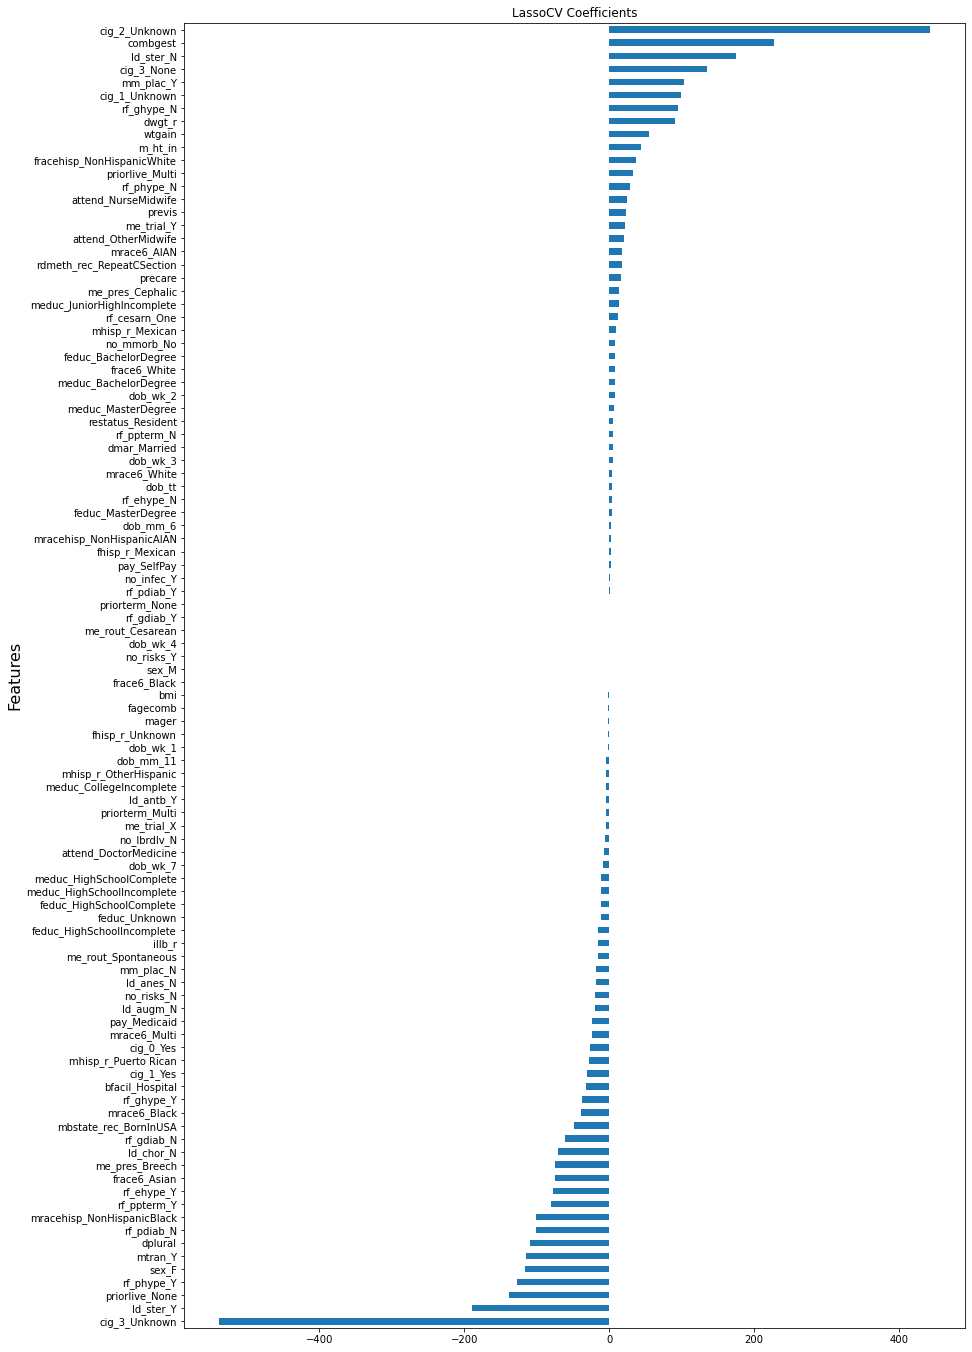

In [55]:
fig, ax = plt.subplots(figsize=(14,24))
model_coef.loc[model_coef['values'] !=0].plot.barh(x='features', y= 'values', ax= ax, legend=False)
ax.set_ylabel('Features', fontsize=16)
ax.set_title('LassoCV Coefficients')
fig.savefig('lassocvcoef', bbox_inches = 'tight', pad_inches=0.5)

### Gestation Period: the most significant feature
According to this lasso model, gestation period has the largest impact on determining baby weight as the values are continuous. <br>
To read this correctly, for every 2.5 weeks(one std move of gestation) will equate to an increase baby weight by 227 grams. <br>


In [23]:
# for every 2.4 weeks of gestation, baby weight increases by 227
X['combgest'].std()

2.4268987955651684

### Race
The linear model had positive coefficients when the mother was white and negative coefficients if mother was asian or black. <br>
This could be a genetics formula or could be a proxy of some social imbalance. <br>
Definitely more research needs to be done here.

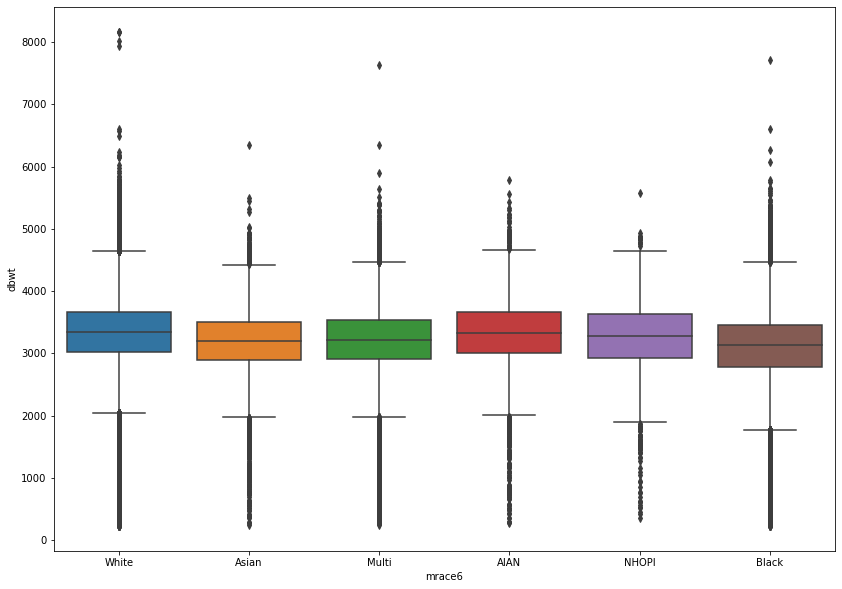

In [31]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='mrace6', y='dbwt', data = df, ax = ax)